In [155]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [156]:
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
# pp.pprint(vgg)

In [157]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

## Computing the content cost

In [158]:
def compute_content_cost(content_output,generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    _,n_H,n_W,n_C = a_C.get_shape().as_list()
    
    j_content = tf.reduce_sum(tf.square(a_C-a_G))/(4.0*n_H,n_W,n_C)
    
    return j_content
    

### Generating Gram matrix

In [159]:
def gram_matrix(A):
    
    return tf.matmul(A,tf.transpose(A))

## Computing Style Cost

In [160]:
def compute_layer_style_cost(a_S,a_G):
    
    _,n_H,n_W,n_C = a_S.get_shape().as_list()
    
    a_S_unrolled = tf.transpose(tf.reshape(a_S,(-1,n_C)))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,(-1,n_C)))
    
    G_a_S = gram_matrix(a_S_unrolled)
    G_a_G = gram_matrix(a_G_unrolled)
    
    J_style_layer = tf.reduce_sum(tf.square(G_a_S - G_a_G))/(4.0 *(( n_H * n_W * n_C)**2))
    
    return J_style_layer
    

In [161]:
for layer in vgg.layers:
    print(layer.name)

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [162]:
vgg.get_layer('block3_conv1').output

<KerasTensor: shape=(None, 100, 100, 256) dtype=float32 (created by layer 'block3_conv1')>

In [163]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [164]:
### you cannot edit this cell

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    J_style = 0

    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

In [165]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style

    return J

(1, 400, 400, 3)


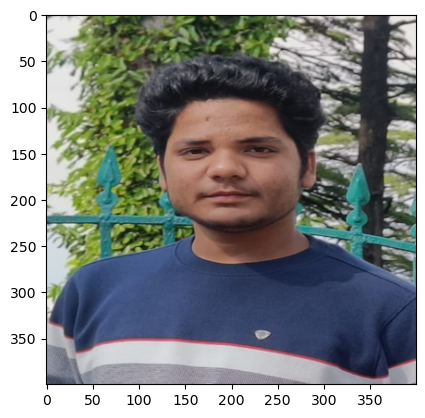

In [166]:
content_image = np.array(Image.open('priyanshu.jpg').resize([400,400]))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


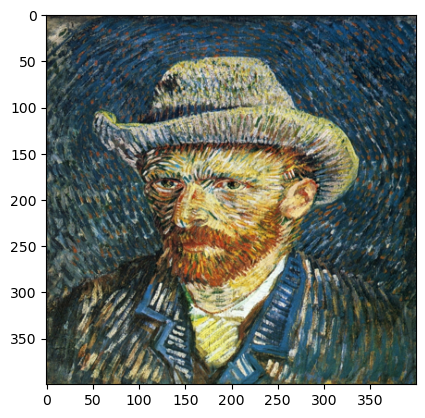

In [167]:
style_image =  np.array(Image.open("style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


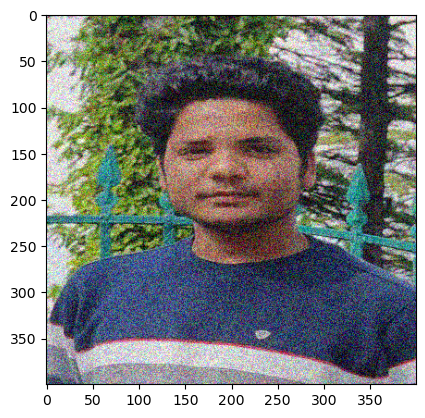

In [226]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image = tf.Variable(generated_image, name='generated_image:0', trainable=True)


print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()


In [227]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [228]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [229]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [240]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [252]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [253]:
vgg_model_outputs.summ

In [231]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [232]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [233]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
#     print(generated_image)
    
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        ### START CODE HERE
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        #(1 line)

        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content =  compute_content_cost(a_C, a_G)
        # Compute the total cost
        J =total_cost(J_content, J_style,alpha = 10, beta = 40)
        
#         print(J)
        
        ### END CODE HERE
    
    print(generated_image)
        
    grad = tape.gradient(J, generated_image)
    print(grad)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [234]:
train_step(generated_image)

<tf.Variable 'generated_image:0:0' shape=(1, 400, 400, 3) dtype=float32>
Tensor("gradient_tape/model_7/block1_conv1/Conv2D/Conv2DBackpropInput:0", shape=(1, 400, 400, 3), dtype=float32)
<tf.Variable 'generated_image:0:0' shape=(1, 400, 400, 3) dtype=float32>
Tensor("gradient_tape/model_7/block1_conv1/Conv2D/Conv2DBackpropInput:0", shape=(1, 400, 400, 3), dtype=float32)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([27886.162, 31905.242, 26808.127], dtype=float32)>

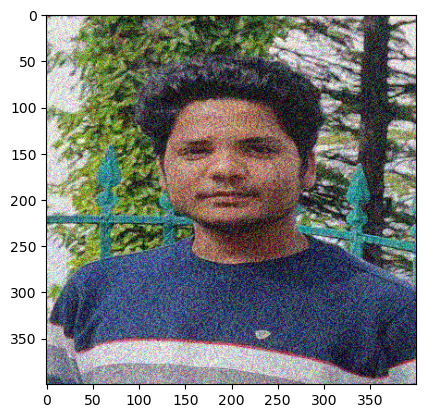

In [236]:
plt.imshow(generated_image[0])

0
Epoch 0


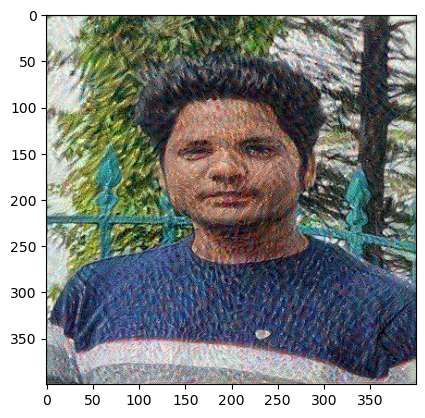

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
Epoch 250


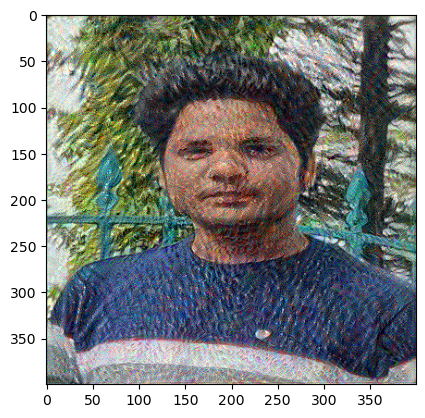

251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500


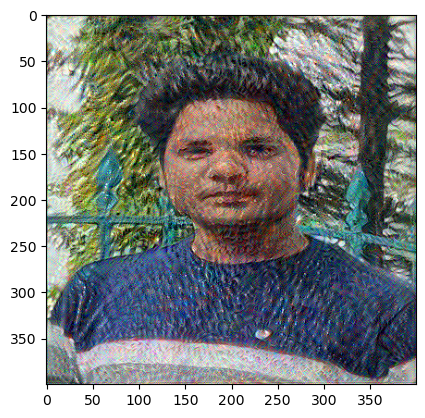

501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548


KeyboardInterrupt: 

In [239]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    print(i)
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i}")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"image_{i}.jpg")
        plt.show() 